In [1]:
from tqdm import tqdm
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from math import log, sqrt, pi
import argparse
from torch import nn, optim
from torch.autograd import Variable, grad
from scipy import linalg as la
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as tfms
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import utils
from PIL import Image
import random
from tqdm import trange
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix

torch.set_num_threads(5)  
torch.set_num_interop_threads(5)  

import open_clip

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")



model,_, preprocess =  open_clip.create_model_and_transforms("ViT-L-14", pretrained='laion2b_s32b_b82k') #ViTB/32
model = model.to(device)
tokenizer = open_clip.get_tokenizer('ViT-L-14')





def seed_everything(seed):
    """
    Changes the seed for reproducibility. 
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def get_transform():
    orig_w = 178
    orig_h = 218
    orig_min_dim = min(orig_w, orig_h)
    target_resolution = (224, 224)

    transform = transforms.Compose([
        transforms.Resize(target_resolution),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                      [0.229, 0.224, 0.225])
    ])
    return transform


class ConfounderDataset(Dataset):
    def __init__(self, root_dir,
                 target_name, confounder_names,
                 model_type=None, augment_data=None):

        
        raise NotImplementedError

    def __len__(self):
        if self.split == 'train':
            return len(self.train_filename_array)
        if self.split == 'test':
            return len(self.test_filename_array)

    def __getitem__(self, idx):
        if self.split == 'train': 
            y = self.train_y_array[idx]
            y = torch.tensor(y)
            a = self.train_group_array[idx]
            g = torch.tensor(a)
            img_filename = self.train_filename_array[idx]
            img = Image.open(img_filename).convert('RGB')
            x = preprocess(img)

        if self.split == 'test': 
            y = self.test_y_array[idx]
            a = self.test_group_array[idx]
            y = torch.tensor(y)
            g = torch.tensor(a)
            img_filename = self.test_filename_array[idx]
            img = Image.open(img_filename).convert('RGB')
            x = preprocess(img)
        return x,y,g


class MetaDatasetCatDog(ConfounderDataset):
    def __init__(self, root_dir,
                 target_name, confounder_names, split,
                 model_type=None,
                 augment_data=False,
                 group_id=None):

        self.root_dir = root_dir
        self.target_name = target_name
        self.confounder_names = confounder_names
        self.model_type = model_type
        self.augment_data = augment_data
        self.RGB = True
        self.n_confounders = 1
        self.split = split
        self.train_data_dir = os.path.join(self.root_dir, "train")
        self.test_data_dir = os.path.join(self.root_dir, 'test')
        self.n_classes = 2
        self.n_groups = 4
        cat_dict = {0: ["sofa"], 1: ["bed"]}
        dog_dict = {0: ['bench'], 1: ['bike']}
        self.test_groups = { "cat": ["shelf"], "dog": ["shelf"]}
        self.train_groups = {"cat": cat_dict, "dog": dog_dict}
        self.train_filename_array, self.train_group_array, self.train_y_array = self.get_data(self.train_groups,
                                                                                              is_training=True)
        self.test_filename_array, self.test_group_array, self.test_y_array = self.get_data(self.test_groups,
                                                                                           is_training=False)


        self.train_filename_array = [
            f for f in self.train_filename_array if not os.path.isdir(f)
        ]
        self.test_filename_array = [
            f for f in self.test_filename_array if not os.path.isdir(f)
        ]

        # split test and validation set
        np.random.seed(100)
        test_idxes = np.arange(len(self.test_group_array))
        val_idxes, _ = train_test_split(np.arange(len(test_idxes)), test_size=0.85, random_state=0)
        test_idxes = np.setdiff1d(test_idxes, val_idxes)
        
        # define the split array
        self.train_split_array = np.zeros(len(self.train_group_array))
        self.test_split_array = 2 * np.ones(len(self.test_group_array))
        self.test_split_array[val_idxes] = 1

        self.filename_array = np.concatenate([self.train_filename_array, self.test_filename_array])
        self.group_array = np.concatenate([self.train_group_array, self.test_group_array])
        self.split_array = np.concatenate([self.train_split_array, self.test_split_array])
        self.split_dict = {'train': 0, 'val': 1, 'test': 2}

        self.y_array = np.concatenate([self.train_y_array, self.test_y_array])
        self.y_array_onehot = torch.zeros(len(self.y_array), self.n_classes)
        self.y_array_onehot = self.y_array_onehot.scatter_(1, torch.tensor(self.y_array).unsqueeze(1), 1).numpy()
        self.mix_array = [False] * len(self.y_array)

        if group_id is not None:
            idxes = np.where(self.group_array == group_id)
            self.filename_array = self.filename_array[idxes]
            self.group_array = self.group_array[idxes]
            self.split_array = self.split_array[idxes]
            self.y_array = self.y_array[idxes]
            self.y_array_onehot = self.y_array_onehot[idxes]

        self.precomputed = False
        self.train_transform = get_transform()
        self.eval_transform = get_transform()

        self.domains = self.group_array
        self.n_groups = len(np.unique(self.group_array))

    def get_group_array(self):
        return self.group_array

    def get_label_array(self):
        return self.y_array

    def group_str(self, group_idx, train=False):
        if not train:
            if group_idx < len(self.test_groups['cat']):
                group_name = f'y = cat'
                group_name += f", attr = {self.test_groups['cat'][group_idx]}"
            else:
                group_name = f"y = dog"
                group_name += f", attr = {self.test_groups['dog'][group_idx - len(self.test_groups['cat'])]}"
        else:
            if group_idx < len(self.train_groups['cat']):
                group_name = f'y = cat'
                group_name += f", attr = {self.train_groups['cat'][group_idx][0]}"
            else:
                group_name = f"y = dog"
                group_name += f", attr = {self.train_groups['dog'][group_idx - len(self.train_groups['cat'])][0]}"
        return group_name

    def get_data(self, groups, is_training):
        filenames = []
        group_ids = []
        ys = []
        id_count = 0
        animal_count = 0
        for animal in groups.keys():
            if is_training:
                for _, group_animal_data in groups[animal].items():
                    for group in group_animal_data:
                        for file in os.listdir(f"{self.train_data_dir}/{animal}/{animal}({group})"):
                            filenames.append(os.path.join(f"{self.train_data_dir}/{animal}/{animal}({group})", file))
                            group_ids.append(id_count)
                            ys.append(animal_count)
                    id_count += 1
            else:
                for group in groups[animal]:
                    for file in os.listdir(f"{self.test_data_dir}/{animal}/{animal}({group})"):
                        filenames.append(os.path.join(f"{self.test_data_dir}/{animal}/{animal}({group})", file))
                        group_ids.append(id_count)
                        ys.append(animal_count)
                    id_count += 1
            animal_count += 1
        return filenames, np.array(group_ids), np.array(ys)




data_dir = r"../../../Dataset/data/metashifts/metashifts/MetaDatasetCatDog"
seed = 1
batch_size = 1

target = 'cat'
confounder_names = 'background'

training_metashift_dataset  = MetaDatasetCatDog(data_dir,  target, confounder_names, 'train')
test_metashift_dataset  = MetaDatasetCatDog(data_dir,  target, confounder_names, 'test')


training_data_loader  = torch.utils.data.DataLoader(dataset = training_metashift_dataset,
                                                batch_size= batch_size,
                                                shuffle=True,
                                                drop_last=True,
                                                num_workers=0)

test_data_loader  = torch.utils.data.DataLoader(dataset = test_metashift_dataset,
                                                batch_size= batch_size,
                                                drop_last=True,
                                                shuffle=True,
                                                num_workers=2)


print("Done")

Done


Testing:   5%|███▎                                                                     | 25/541 [00:02<00:53,  9.72it/s]

<Figure size 1000x500 with 0 Axes>

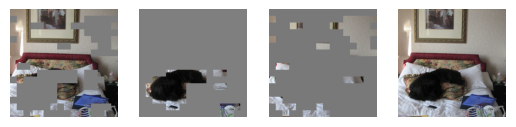

Testing:   5%|███▌                                                                     | 26/541 [00:03<01:06,  7.73it/s]

<Figure size 1000x500 with 0 Axes>

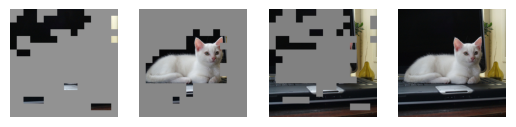

Testing:   5%|███▋                                                                     | 27/541 [00:03<01:14,  6.94it/s]

<Figure size 1000x500 with 0 Axes>

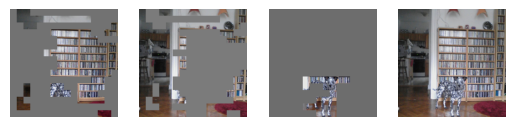

Testing:   5%|███▊                                                                     | 28/541 [00:03<01:55,  4.45it/s]

<Figure size 1000x500 with 0 Axes>

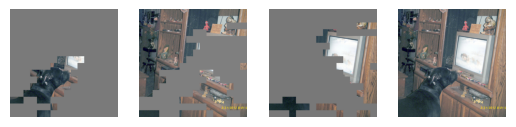

Testing:   5%|███▉                                                                     | 29/541 [00:03<01:50,  4.65it/s]

<Figure size 1000x500 with 0 Axes>

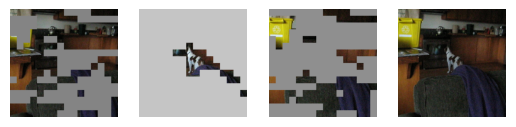

Testing:   6%|████                                                                     | 30/541 [00:04<01:42,  4.98it/s]

<Figure size 1000x500 with 0 Axes>

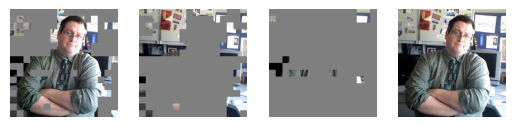

Testing:   6%|████▏                                                                    | 31/541 [00:04<01:38,  5.15it/s]

<Figure size 1000x500 with 0 Axes>

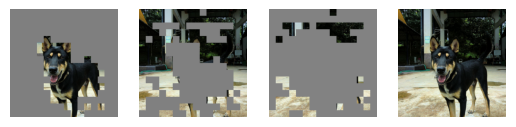

Testing:   6%|████▎                                                                    | 32/541 [00:04<01:36,  5.25it/s]

<Figure size 1000x500 with 0 Axes>

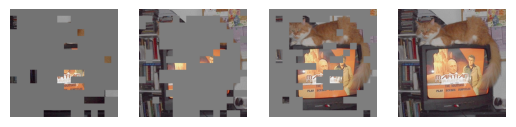

Testing:   6%|████▍                                                                    | 33/541 [00:04<01:35,  5.30it/s]

<Figure size 1000x500 with 0 Axes>

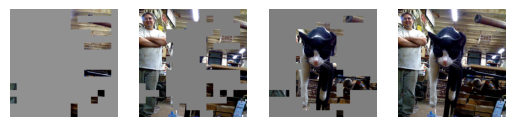

Testing:   6%|████▌                                                                    | 34/541 [00:04<01:33,  5.39it/s]

<Figure size 1000x500 with 0 Axes>

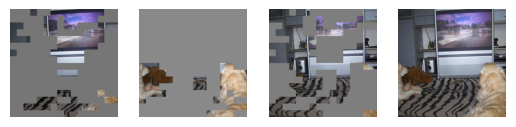

Testing:   6%|████▋                                                                    | 35/541 [00:04<01:33,  5.44it/s]

<Figure size 1000x500 with 0 Axes>

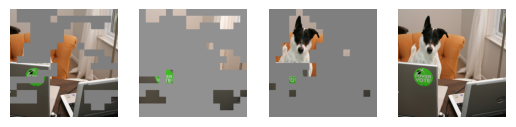

Testing:   7%|████▊                                                                    | 36/541 [00:05<01:31,  5.50it/s]/home/jw-server3/a/lu876/miniconda3/envs/DLcourse/lib/python3.9/site-packages/torchvision/transforms/functional.py:282: RuntimeWarning: invalid value encountered in cast
  npimg = (npimg * 255).astype(np.uint8)


<Figure size 1000x500 with 0 Axes>

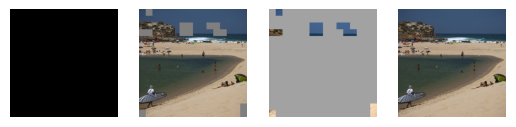

Testing:   7%|████▉                                                                    | 37/541 [00:05<01:32,  5.44it/s]/home/jw-server3/a/lu876/miniconda3/envs/DLcourse/lib/python3.9/site-packages/torchvision/transforms/functional.py:282: RuntimeWarning: invalid value encountered in cast
  npimg = (npimg * 255).astype(np.uint8)


<Figure size 1000x500 with 0 Axes>

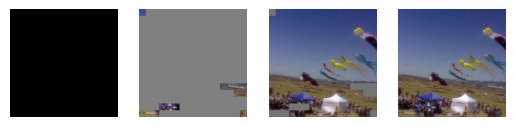

Testing:   7%|█████▏                                                                   | 38/541 [00:05<01:30,  5.54it/s]

<Figure size 1000x500 with 0 Axes>

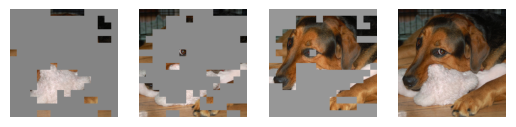

Testing:   7%|█████▎                                                                   | 39/541 [00:05<01:34,  5.32it/s]

<Figure size 1000x500 with 0 Axes>

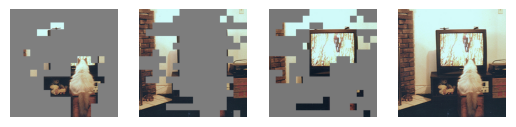

Testing: 100%|████████████████████████████████████████████████████████████████████████| 541/541 [00:56<00:00,  9.52it/s]


Accuracy for label=1, sensitive=1: 0.90850 (total: 306.0)
Accuracy for label=0, sensitive=0: 0.91489 (total: 235.0)
Overall accuracy: 0.91128 (total: 541)


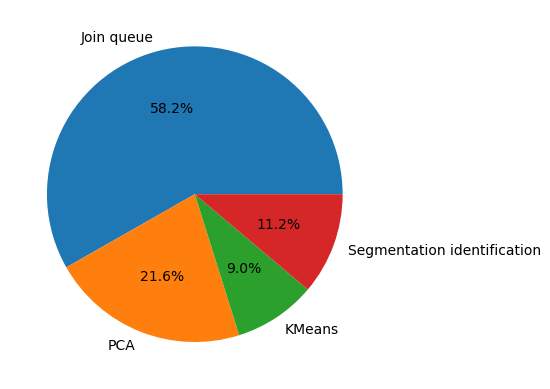

In [2]:
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import minmax_scale
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter
from sklearn.cluster import AgglomerativeClustering
from collections import deque, defaultdict
import time


queue_length = 24 
segment_num = 3
pca_feature_num = 3

def pca_single_modality(pca_features, mask, n_imgs, img):  
    to_pil_image = tfms.ToPILImage()
    for i in range(3):
        pca_features[:, i] = (pca_features[:, i] - pca_features[:, i].min()) / (pca_features[:, i].max() - pca_features[:, i].min())
    plt.figure(figsize=(5, 5))
    
    for i in range(n_imgs):
        fig, ax = plt.subplots(1, 3)
        img[i] = (img[i] - img[i].min()) / (img[i].max() - img[i].min())
        image_np = to_pil_image(img[i].cpu().squeeze(0))
        ax[0].imshow(image_np)    
        print(pca_features[i*16*16 :(i+1)*16*16, :].shape)
        image_pca = torch.tensor(pca_features[i*16*16 :(i+1)*16*16, :].reshape(16,16, 3))                    
        ax[1].imshow(image_pca.cpu().numpy())
        ax[2].imshow(mask[i*16*16 :(i+1)*16*16, :].reshape(16,16, 3))
    plt.show()
    plt.close()



def pca_single_modality_queue(pca_features, mask, n_imgs, img, id, imshow = False):  
    to_pil_image = tfms.ToPILImage()
    for i in range(segment_num):
        pca_features[:, i] = (pca_features[:, i] - pca_features[:, i].min()) / (pca_features[:, i].max() - pca_features[:, i].min())

    if id < queue_length:
        image_pca = torch.tensor(pca_features[id*16*16 : (id + 1)*16*16, :].reshape(16,16, pca_feature_num))    
    else:
        image_pca = torch.tensor(pca_features[-16*16 :, :].reshape(16,16, pca_feature_num))

    if id < queue_length:
        mask_tensor = mask[id*16*16 : (id + 1)*16*16, :].reshape(16,16, segment_num)
    else:
        mask_tensor = mask[-16*16 :, :].reshape(16,16, segment_num)
    
    if imshow == True:
        plt.figure(figsize=(5, 5))
        fig, ax = plt.subplots(1, segment_num)
        img = (img - img.min()) / (img.max() - img.min())
        image_np = to_pil_image(img.cpu().squeeze(0))
        ax[0].imshow(image_np)                 
        ax[1].imshow(image_pca.cpu().numpy())
        ax[2].imshow(mask_tensor)
        plt.show()
        plt.close()
    return mask_tensor


def masked_img(image, mask, imshow, prob):  # image: (3, 224, 224), mask: (16, 16, 3)
    to_pil_image = tfms.ToPILImage()
    mask_single_channel = torch.argmax(mask, dim=-1)  # Shape: [16, 16]
    mask_upsampled = F.interpolate(mask_single_channel.unsqueeze(0).unsqueeze(0).float(),
                                    size=(224, 224), mode="nearest").squeeze().long()  # Shape: [224, 224]
    binary_masks = [(mask_upsampled == value).float() for value in range(segment_num)]
    masked_images = [image * binary_mask.unsqueeze(0) for binary_mask in binary_masks]
    normalized_images = []
    show_images = []
    for masked_image in masked_images:
        if masked_image.max() > masked_image.min():
            normalized_image = masked_image
        else:
            normalized_image = masked_image  
        show_image = (masked_image - masked_image.min()) / (masked_image.max() - masked_image.min())
        normalized_images.append(normalized_image)
        show_images.append(show_image)
    if imshow == True:
        plt.figure(figsize=(10, 5))
        fig, ax = plt.subplots(1, segment_num+1)
        for i in range(segment_num):
            image_np = to_pil_image(show_images[i].squeeze(0).cpu())
            ax[i].imshow(image_np)
            ax[i].axis('off')
        img = (image - image.min()) / (image.max() - image.min())
        image_np_o = to_pil_image(img.cpu().squeeze(0))
        ax[segment_num].imshow(image_np_o) 
        ax[segment_num].axis('off')
        plt.show()
    return normalized_images
    

def my_convert_ids_to_tokens(tokenizer, token_ids):
    if isinstance(token_ids, torch.Tensor):
        token_ids = token_ids.tolist()
    
    tokens = []
    for tid in token_ids:
        if tid in tokenizer.decoder:
            tokens.append(tokenizer.decoder[tid])
        else:
            tokens.append(f"[UNK_{tid}]")
    return tokens


def fast_PCA(X):
    X = X.to(device)
    U, S, Vt = torch.svd_lowrank(X, q=16)
    k = pca_feature_num 
    PCs = Vt[:, :k]  
    X_pca = X @ PCs  
    return X_pca


def test_epoch(vlm,   dataloader):  
    vlm = vlm.to(device)
    vlm.eval()   
    visual = vlm.visual
    img_show = 40
    vlm.visual.pool_type = None
    T =1
    texts_label = ["a photo of a cat", "a photo of a dog"] 
    general_label = ["a photo of pet."]
    text_label_tokened = tokenizer(texts_label).to(device)
    general_label_tokened = tokenizer(general_label).to(device)
    text_embeddings = vlm.encode_text(text_label_tokened)
    vlm.text_pool_type = 'last'
    general_embeddings = vlm.encode_text(general_label_tokened)
    iteration = 0
    queue = deque()
    pca = PCA(n_components=3)
    overall_correct = 0
    overall_total = 0
    correct = defaultdict(float)
    total = defaultdict(float)

    for _, (sample, _, _) in enumerate(tqdm(dataloader, desc="Testing")):
        sample = sample.to(device)
        img_embeds = vlm.encode_image(sample)[:,1:,:].squeeze(0)  #torch.Size([1, 257, 768])
        img_embeds = img_embeds.detach().cpu().numpy()   
        queue.append(img_embeds)
        iteration += 1
        if iteration> queue_length:
            break
            
    iteration = 0
    time_1 = 0
    time_2 = 0
    time_3 = 0
    time_4 = 0
    for step, (test_input, test_target, sensitive_real) in enumerate(tqdm(dataloader, desc="Testing")):
        with torch.no_grad(): 
            start_step1 = time.time()
            gt = test_target.detach().cpu().numpy()
            sen = sensitive_real.detach().cpu().numpy()      
            test_input = test_input.to(device)
            img_embeddings = vlm.encode_image(test_input)  #torch.Size([1, 257, 768])
            comb_feature_gpu = img_embeddings[:,1:,:].squeeze(0)
            comb_feature = comb_feature_gpu.detach().cpu().numpy() 
            
            if step < queue_length:
                combined_array = torch.vstack([torch.from_numpy(arr) if isinstance(arr, np.ndarray) else arr for arr in queue]).to(device)
            else:            
                queue.popleft()
                queue.append(comb_feature)
                combined_array = torch.vstack([torch.from_numpy(arr) if isinstance(arr, np.ndarray) else arr for arr in queue]).to(device)

            end_step1 = time.time()
            lapse = end_step1 - start_step1
            time_1+= lapse
            start_step2 = time.time()
            pca_features = fast_PCA(combined_array).cpu().numpy()

            end_step2 = time.time()
            lapse_2 = end_step2 - start_step2
            time_2+= lapse_2
            
            start_step3 = time.time()
            smoothed_data = gaussian_filter(pca_features, sigma=(0.71, 0))
            kmean_cluster = KMeans(n_clusters=segment_num, random_state=0).fit_predict(smoothed_data)
            encoder = OneHotEncoder(sparse_output=False)
            one_hot_mask = encoder.fit_transform(kmean_cluster.reshape(-1, 1))
            pca_features_rgb = pca_features.copy()
            end_step3 = time.time()
            lapse_3 = end_step3 - start_step3
            time_3+= lapse_3

            start_step4 = time.time()
            mask = pca_single_modality_queue(pca_features_rgb, one_hot_mask, batch_size, test_input, step)
            msks = masked_img(test_input.cpu(), torch.tensor(mask).cpu(), False, None)
            mask_single_channel = torch.argmax(torch.tensor(mask).cpu(), dim=-1).view(16, 16).contiguous().view(-1)
            local_rep = [comb_feature_gpu[mask_single_channel == i] for i in range(segment_num)]
            seg_embedding = torch.vstack([
                torch.mean(local_rep[i], dim=0, keepdim=True) for i in range(segment_num)
            ])
            nan_mask = torch.isnan(seg_embedding).any(dim=1)  
            seg_embedding = torch.nan_to_num(seg_embedding, nan=10)
            general_embeddings = general_embeddings / general_embeddings.norm(dim=1, keepdim=True)
            seg_cosine_similarity = torch.mm(-seg_embedding, general_embeddings.t())
            probs = seg_cosine_similarity.softmax(dim = 0)
            conf, predic = torch.max(probs.data, 0)
            
            end_step4 = time.time()
            lapse_4 = end_step4 - start_step4
            time_4+= lapse_4

            if step < img_show and step > queue_length:
                masked_img(test_input.cpu(), torch.tensor(mask).cpu(), True, probs)            
            #print('********************************************************************')
            high_attention_seg = msks[predic]
            high_embedding = vlm.encode_image(high_attention_seg.to(device))[:,0,:] 
            high_embedding = high_embedding.squeeze(1)
            high_embedding = high_embedding/high_embedding.norm(dim=1, keepdim=True)
            text_embeddings = text_embeddings/text_embeddings.norm(dim=1, keepdim=True)
            cosine_similarity = torch.mm(high_embedding, text_embeddings.t())
            logits_per_image = cosine_similarity 
            probs = logits_per_image.softmax(dim=1)
            _, predic = torch.max(probs.data, 1)
            predic = predic.detach().cpu()

            label = test_target.detach().cpu()
            overall_correct += (predic == label).sum()
            overall_total += len(test_target.reshape(-1).detach().cpu())
            unique_groups = np.unique(np.stack([label, sensitive_real], axis=1), axis=0)
            for group in unique_groups:
                mask = (label == group[0]) & (sensitive_real == group[1])
                correct[tuple(group)] += (predic[mask] == label[mask]).sum()
                total[tuple(group)] += mask.sum()

    for group, correct_count in correct.items():
        accuracy = correct_count / total[group]
        print(f'Accuracy for label={group[0]}, sensitive={group[1]}: {accuracy:.5f} (total: {total[group]})')

    overall_accuracy = overall_correct / overall_total
    print(f'Overall accuracy: {overall_accuracy:.5f} (total: {overall_total})')
    labels = ['Join queue', 'PCA', 'KMeans', 'Segmentation identification']
    durations = [time_1, time_2, time_3,time_4]
    plt.pie(durations, labels=labels, autopct='%1.1f%%')
    plt.show()
    

seed_everything(10)  
model = model.to(device)
model = model.eval()
test_epoch(model, test_data_loader)